## ***How RAG-Powered Tool Calling Works in LangGraph***

**Agents and Tools**: In LangGraph, an agent is an LLM-driven entity that can reason about which actions (tools) to take in response to a user query. Tools can include document retrievers, web search APIs, or custom user-defined functions.

--- 

**Node-Based Workflow**: Each tool or action is represented as a node in the graph. The LLM node decides which tool to invoke by analyzing the user's input and outputs the tool name and necessary arguments. This information is passed to a tool node, which executes the tool and returns the result to the LLM for further reasoning or response generation.

---- 
- Control Flow and Planning: LangGraph allows for advanced control flows, such as:

- Routing: Directing queries to the most appropriate retrieval or generation node based on the question type.

- Fallback: Using backup tools (like a web search) if the primary retrieval method fails to find relevant information.

- Self-Reflection: Evaluating the quality of retrieved information and looping back for corrections if needed.

- State Management: LangGraph manages the application state, tracking the input question, retrieved context, and generated answer throughout the workflow.
--- 

### Example Use Cases
- ***Web Search Integration***: An agent can decide to use a web search tool if the internal knowledge base does not contain the needed information.

- ***Document Retrieval***: For factual queries, the agent may use a vector database retriever to fetch relevant documents, then generate an answer grounded in those documents.

- ***Custom Tools***: Agents can be extended with custom tools for specialized tasks, such as summarization, translation, or data extraction.

---

### ***Benefits of RAG-Powered Tool Calling with LangGraph***

- Dynamic and Adaptive: Agents can intelligently choose the best tool for each query, improving accuracy and user satisfaction.

- Scalable and Modular: The graph-based design makes it easy to add, remove, or modify tools and control flows.

- Robustness: Built-in mechanisms for fallback and self-correction lead to more reliable and informative responses.

--- 

### Getting Started
- To implement RAG-powered tool calling with LangGraph:

- Define your tools (retrievers, web search, custom functions).

- Set up your data indexing and retrieval pipeline.

- Model your workflow as a graph, specifying nodes for each tool and control logic for transitions.

Use LangGraph's orchestration to manage state and execute the workflow, allowing the agent to call tools as needed.

In [2]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv
load_dotenv()

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

In [3]:
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})

In [4]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(retriever, "retriever_tool",   "Information related to Gym History & Founder, Operating Hours, Membership Plans, Fitness Classes, Personal Trainers, and Facilities & Equipment of Peak Performance Gym",
)

In [7]:
@tool
def off_topic():
     """Catch all Questions NOT related to Peak Performance Gym's history, hours, membership plans, fitness classes, trainers, or facilities"""
     return "Forbidden - do not respond to the user"

In [8]:
tools = [retriever_tool, off_topic]

In [9]:
from typing import Annotated, Sequence, Literal, TypedDict
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.graph import add_messages , END, START, StateGraph
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


def agent(state):
    messages = state['messages']
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}



In [10]:
def should_continue(state) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [11]:
from langgraph.prebuilt import ToolNode
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

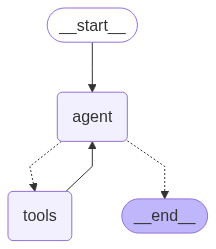

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [13]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]}
)

{'messages': [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='b20c9135-203a-4d55-85c2-779eb621a1bf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LKDEP2H1zHxt7GWNFRHbXC86', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 122, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1900cf03-36fe-4b4d-bd56-4e277d2f5e77-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'call_LKDEP2H1zHxt7GWNFRHbXC86', 'type': 'tool_call'}], usage_metadata={'input_tokens': 122, 'output_tokens': 10, 'total_t

In [14]:
graph.invoke(input={
    "messages": [HumanMessage(content="Who is the owner and what are the timings?")]
})

{'messages': [HumanMessage(content='Who is the owner and what are the timings?', additional_kwargs={}, response_metadata={}, id='8cc33a1f-de90-433a-bcf3-c117998b11a4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SoRemV7vMH9YWim63srRDGme', 'function': {'arguments': '{"query": "owner"}', 'name': 'retriever_tool'}, 'type': 'function'}, {'id': 'call_9X4C3XDCAo96Bmh41ntyS3xQ', 'function': {'arguments': '{"query": "timings"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 123, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ad4f12e3-8e92-4f75-921e-843c4206c4b7-0', tool_ca